In [ ]:
!pip install transformers datasets evaluate -q
!pip install jiwer -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.7 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset

ds = load_dataset("Attila1011/img_caption_EN_AppleFlair_Blip", split='train[:500]')
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/375 [00:00<?, ?B/s]

train-00000-of-00005.parquet:   0%|          | 0.00/425M [00:00<?, ?B/s]

train-00001-of-00005.parquet:   0%|          | 0.00/395M [00:00<?, ?B/s]

train-00002-of-00005.parquet:   0%|          | 0.00/401M [00:00<?, ?B/s]

train-00003-of-00005.parquet:   0%|          | 0.00/402M [00:00<?, ?B/s]

train-00004-of-00005.parquet:   0%|          | 0.00/410M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset({
    features: ['img', 'text_EN'],
    num_rows: 500
})

In [ ]:
ds = ds.train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

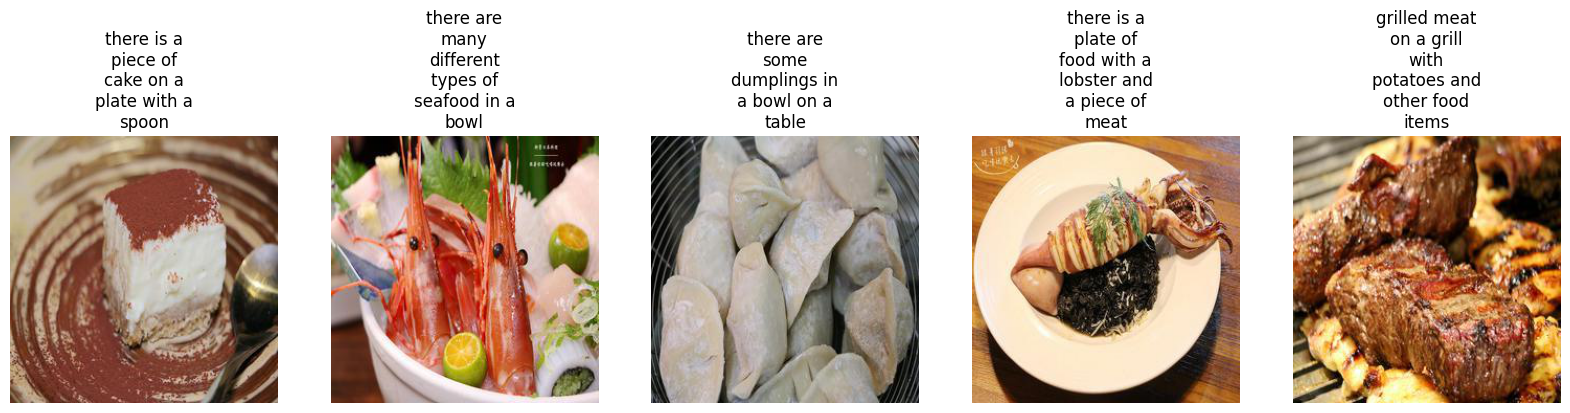

In [ ]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["img"]) for i in range(5)]
sample_captions = [train_ds[i]["text_EN"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

## Preprocess the dataset

In [ ]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
def transforms(example_batch):
    images = [x for x in example_batch["img"]]
    captions = [x for x in example_batch["text_EN"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [ ]:
train_ds

Dataset({
    features: ['img', 'text_EN'],
    num_rows: 450
})

In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

## traning model

In [ ]:
from evaluate import load
import torch

wer = load("wer")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [ ]:
from transformers import TrainerCallback

class ClearCacheCallback(TrainerCallback):
    def __init__(self, clear_every_n_steps=10):
        self.clear_every_n_steps = clear_every_n_steps

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % 10 == 0:
            torch.cuda.empty_cache()
            print(f"Cleared cache at step {state.global_step}")

# Now, instantiate the callback
clear_cache_callback = ClearCacheCallback(clear_every_n_steps=10)

In [ ]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=50,
    fp16=True,
    per_device_train_batch_size=4,  # Reduced batch size
    per_device_eval_batch_size=4,   # Reduced batch size
    gradient_accumulation_steps=8,  # Increased accumulation steps
    save_total_limit=2,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=100,  # Less frequent saves
    logging_steps=10,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
    report_to="tensorboard"
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    callbacks=[clear_cache_callback]
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Wer Score
50,5.246800,4.580887,17.152801
100,0.775800,0.467192,7.780985
150,0.033700,0.042370,2.353141
200,0.008900,0.040098,3.303905
250,0.002200,0.038838,5.855688
300,0.000800,0.041062,4.674024
350,0.000400,0.040963,3.867572
400,0.000300,0.040876,4.176570
450,0.000200,0.041391,4.013582
500,0.000200,0.041412,3.977929


Cleared cache at step 10
Cleared cache at step 20
Cleared cache at step 30
Cleared cache at step 40
Cleared cache at step 50
Cleared cache at step 60
Cleared cache at step 70
Cleared cache at step 80
Cleared cache at step 90
Cleared cache at step 100
Cleared cache at step 110
Cleared cache at step 120
Cleared cache at step 130
Cleared cache at step 140
Cleared cache at step 150
Cleared cache at step 160
Cleared cache at step 170
Cleared cache at step 180
Cleared cache at step 190
Cleared cache at step 200
Cleared cache at step 210
Cleared cache at step 220
Cleared cache at step 230
Cleared cache at step 240
Cleared cache at step 250
Cleared cache at step 260
Cleared cache at step 270
Cleared cache at step 280
Cleared cache at step 290
Cleared cache at step 300
Cleared cache at step 310
Cleared cache at step 320
Cleared cache at step 330
Cleared cache at step 340
Cleared cache at step 350
Cleared cache at step 360
Cleared cache at step 370
Cleared cache at step 380
Cleared cache at step

TrainOutput(global_step=700, training_loss=0.7170525214154206, metrics={'train_runtime': 1759.3361, 'train_samples_per_second': 12.789, 'train_steps_per_second': 0.398, 'total_flos': 1.0430258188750848e+16, 'train_loss': 0.7170525214154206, 'epoch': 49.557522123893804})

In [ ]:
trainer.save_model()

In [ ]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

events.out.tfevents.1734201254.f67a4e333abb.500.0:   0%|          | 0.00/24.9k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/osmanh/git-base-pokemon/commit/d847c5f2427e3e12b1117cf569debde944ed08fa', commit_message='End of training', commit_description='', oid='d847c5f2427e3e12b1117cf569debde944ed08fa', pr_url=None, repo_url=RepoUrl('https://huggingface.co/osmanh/git-base-pokemon', endpoint='https://huggingface.co', repo_type='model', repo_id='osmanh/git-base-pokemon'), pr_revision=None, pr_num=None)

## prediction

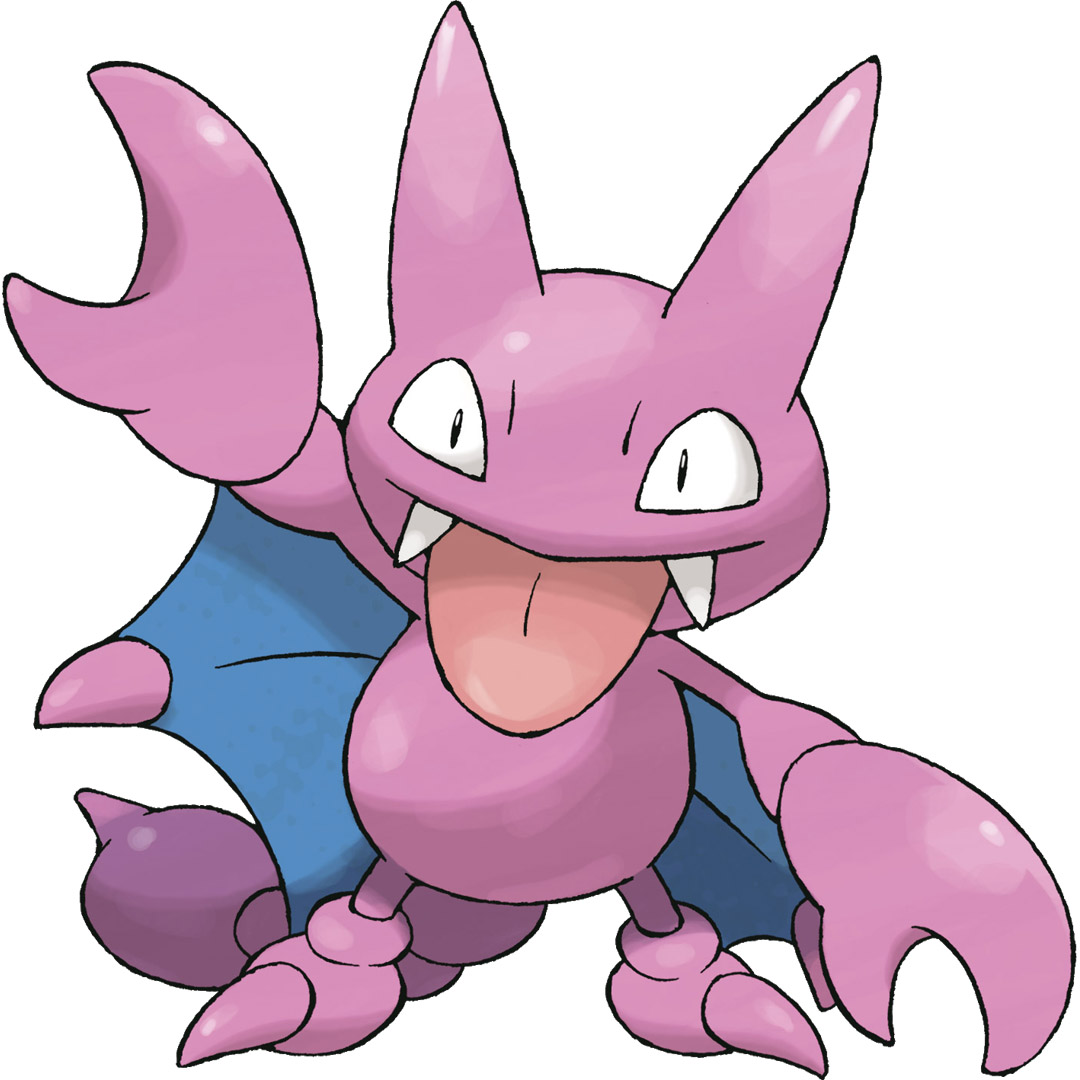

In [ ]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
# Load model directly
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("osmanh/git-base-pokemon")
model = AutoModelForImageTextToText.from_pretrained("osmanh/git-base-pokemon")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

# Move the model to the same device as the input
model.to(device)

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

there are three plates of food on the table with a cup of coffee
